In [1]:
from __future__ import division

import gym
import numpy as np
import random
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.keras as keras
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy.misc
import os
%matplotlib inline
import pdb

import re

import cPickle

In [2]:
from PIL import Image
import cv2

#env_title = 'Assault-v0'
env_title = 'Breakout-v0'
env = gym.make(env_title);

breakout = (env_title == 'Breakout-v0')

[2017-05-27 19:26:13,106] Making new env: Breakout-v0


In [3]:
def downsample84(s):
    s_gray = cv2.cvtColor(s, cv2.COLOR_BGR2GRAY)
    return np.array(Image.fromarray(s_gray).resize((84,84)))

In [4]:
from piaget import Point, Mover, MoverTracker, FramePair, Box, Categorizer
from piaget import init_env, play

/home/ubuntu/env2.7/local/lib/python2.7/site-packages/trackpy/utils.py:46: UserWarning: Due to a bug in Scipy 0.18.0, the (faster) cKDTree cannot be used. For better linking performance, upgrade or downgrade scipy.
  warnings.warn("Due to a bug in Scipy 0.18.0, the (faster) cKDTree cannot "


In [5]:
def processState(states):
    return np.reshape(states,[np.product(states.shape)])

In [6]:
def initial_obs(env, breakout=breakout):
    env.reset()
    if breakout:
        s, r, d, info = env.step(1) # request next ball in breakout
    else:
        s, r, d, info = env.step(np.random.randint(0,env.action_space.n))
    s1, r1, d1, info1 = env.step(np.random.randint(0,env.action_space.n))
    
    s_list = [s, s1]

    return s_list, r1, d1, info1

In [7]:
s_list, r, d, info = initial_obs(env,breakout=True)
s_stack = np.dstack(s_list)
s = processState(s_stack)

#s210 = np.vstack([np.reshape(s,[210*160*3*2])]).astype('float32')

In [8]:
def symmetrize_disps(disps):
    symm_disps = set()
    for disp in disps:
        symm_disps.add(disp)
        symm_disps.add((-disp[0],disp[1]))
        symm_disps.add((disp[0],-disp[1]))
        #symm_disps.add((-disp[0],-disp[1]))
    return list(symm_disps)

def remove_redundant_disps(disps):
    excluded_ids = set()
    for i, d1 in enumerate(disps):
        for j, d2 in enumerate(disps):
            if abs(d1[0]) == abs(d2[0]) \
            and abs(d1[1]) == abs(d2[1])\
            and j>i:
                excluded_ids.add(j)
    return [d for i, d in enumerate(disps) if i not in excluded_ids]

In [9]:
if breakout:
    game_id = 332396
else:
    game_id = 64468
mt_dir = 'mt/' + str(game_id) + '/'
mt_filename = mt_dir + 'mt.pkl'
with open(mt_filename) as f:
    mt = cPickle.load(f)
img_dir = mt.img_dir
mover_dirs = [img_dir + d + '/' for d in os.listdir(img_dir) if d.find('mover') == 0]

excluded_ids = set()

mover_disps = []
for mover_id, m in enumerate(mt.movers):
    traj = m.trajectory
    disp_boxes = [(t1[1]-t0[1])/(t1[0]-t0[0]) for t1, t0 in zip(traj[1:],traj[:-1])]
    disp_pts = [(b.ll + b.ur)/2 for b in disp_boxes]
    disp_unique = {d.to_tuple() for d in disp_pts}
    disp_unique_ints = [(int(d1), int(d2)) for d1, d2 in disp_unique]
    disp_unique_ints = symmetrize_disps(disp_unique_ints)
    disp_unique_ints = remove_redundant_disps(disp_unique_ints)
    mover_disps.append(disp_unique_ints)
    if len(disp_unique_ints) == 0:
        excluded_ids.add(mover_id)

In [10]:
mover_prototypes = []

for mover_id, mover_dir in enumerate(mover_dirs):
    mover_label = int(mover_dir[mover_dir.find('mover')+5:-1])
    list_images = [mover_dir+f for f in os.listdir(mover_dir) if re.search('jpg|JPG', f)]
    mover_images = []
    for image in list_images:
        im = np.array(Image.open(image))
        mover_images.append(im)
    
    n_im = len(mover_images)
    prototypes = [mover_images[i] for i in range(n_im)]
    proto_vars = [np.var(p.flatten()) for p in prototypes]
    not_blank = [i for i in range(n_im) if proto_vars[i] > 0]
    if len(not_blank) == 0:
        #all blank
        excluded_ids.add(mover_id)
        mover_prototypes.append(prototypes[0])
    else:
        proto = prototypes[np.random.choice(not_blank)]
        mover_prototypes.append(proto)
        
# remove exact duplicates
for i, p1 in enumerate(mover_prototypes):
    for j, p2 in enumerate(mover_prototypes):
        if p1.shape == p2.shape:
            if np.var(p2-p1) == 0 and j > i:
                excluded_ids.add(j)
    
mover_prototypes = [p for i, p in enumerate(mover_prototypes)
                    if i not in excluded_ids]
mover_disps = [d for i, d in enumerate(mover_disps)
                    if i not in excluded_ids]


In [11]:
for i, p1 in enumerate(mover_prototypes):
    for j, p2 in enumerate(mover_prototypes):
        if p1.shape == p2.shape and j>i:
            print (i,j,np.var(p2-p1))

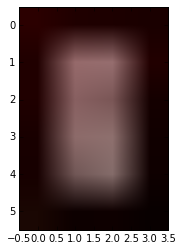

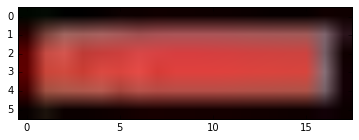

In [12]:
for p in mover_prototypes:
    plt.imshow(p)
    plt.show()

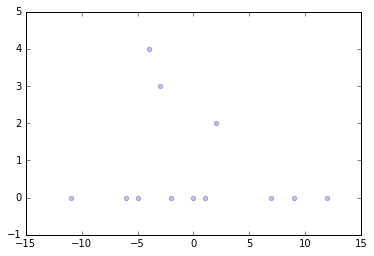

In [13]:
all_disps = reduce(lambda a,b: list(a)+list(b), mover_disps)
#all_disps_for_plot = [(d[0] + np.random.randn()/30,d[1]+np.random.randn()/30) for d in all_disps]
plt.scatter(*zip(*all_disps),alpha=0.25)

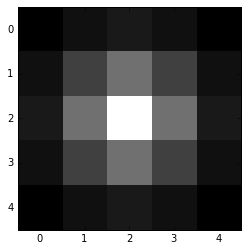

In [14]:
def local_blob(size):
    blob = np.zeros((size, size))
    middle = (size-1)/2
    for i in range(size):
        for j in range(size):
            blob[i,j] = 1./(1+((i-middle)**2 + (j-middle)**2))
    return blob
plt.imshow(local_blob(5),cmap='gray',interpolation='nearest')

### class protoQnetwork below is adapted from https://github.com/awjuliani/DeepRL-Agents

Network architecture is similar to that in the 2014 DeepMind paper.  This version uses piaget's mover images to form a first layer of convolutional filters, and their observed displacements to form the second.

In [70]:
class protoQnetworkNoDisps():
    def __init__(self, h_size, mover_prototypes, mover_disps, blob_size, model_name, dueling=True):
        self.model_name = model_name
        self.blob_size = blob_size
        self.scalarInput =  tf.placeholder(shape=[None,210*160*3*2],dtype=tf.float32)
        self.imageIn = tf.reshape(self.scalarInput/255.,shape=[-1,210,160,3*2])
        
        self.mover_conv_list = []
        self.disp_conv_list = []
        
        for i, proto in enumerate(mover_prototypes):
            self.mover_conv_list.append(self.get_conv_mover(proto, i))        
        
        self.conv_movers = tf.concat(self.mover_conv_list,3)
        
#         for i, disps in enumerate(mover_disps):
#             self.disp_conv_list.append(self.get_conv_disp(disps, i)) 
        
#         self.conv_disps = tf.concat(self.disp_conv_list,3)
        
#         self.conv_dm = tf.concat([self.conv_disps,
#                                             self.conv_movers],3)
        
#         self.conv_dm_pool = slim.pool(self.conv_dm, [4,4], \
#                                          'MAX', 'VALID', stride=[4,4])
        
        self.conv_movers_pool = slim.pool(self.conv_movers, [4,4], \
                                          'MAX', 'VALID', stride=[4,4])
        #Leaky1 = keras.layers.LeakyReLU(0.1)
        self.conv1 = slim.conv2d( \
            inputs=self.conv_movers_pool,num_outputs=32,kernel_size=[4,4],stride=[2,2],
                                 padding='VALID', biases_initializer=None)

        self.conv1_pool = slim.pool(self.conv1, [3,3], \
                                         'MAX', 'VALID', stride=[3,3])
        
        #Leaky2 = keras.layers.LeakyReLU(0.1)
        
        # for width 250: kernel_size=[10,6]
        # for width 210: kernel_size=[8,6]
        self.conv2 = slim.conv2d( \
            inputs=self.conv1_pool,num_outputs=h_size,kernel_size=[8,6],stride=[1,1],
                                 padding='VALID', biases_initializer=None)
        #We take the output from the final convolutional layer and split it into separate advantage and value streams.
        
        self.streamAC,self.streamVC = tf.split(self.conv2,2,3)
        self.streamA = slim.flatten(self.streamAC)
        self.streamV = slim.flatten(self.streamVC)
        xavier_init = tf.contrib.layers.xavier_initializer()
        self.AW = tf.Variable(xavier_init([h_size//2,env.action_space.n]))
        self.VW = tf.Variable(xavier_init([h_size//2,1]))
        
        self.Advantage = tf.matmul(self.streamA,self.AW)
        self.Value = tf.matmul(self.streamV,self.VW) + 0.1 # experimental
        
        #Then combine them together to get our final Q-values.
        if dueling:
            self.Qout = self.Value + tf.subtract(self.Advantage,tf.reduce_mean(self.Advantage,axis=1,keep_dims=True))
        else:
            self.Qout = self.Advantage
        self.predict = tf.argmax(self.Qout,1)
        
        #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,env.action_space.n,dtype=tf.float32)
        
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)
        
        self.td_error = tf.square(self.targetQ - self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.002,
                                             epsilon=1e-3)
        self.trainables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 
                 scope='(?!' + self.model_name + 
                               '/piaget)')
        self.updateModel = self.trainer.minimize(self.loss, 
                                                 var_list=self.trainables)
        
    def get_conv_mover(self, proto, ind):
    
        p0 = proto/(255.)

        p0_mean = np.mean(p0,(0,1))
        p0 = p0 - p0_mean

        p0_norm = np.sqrt(np.sum(p0**2))
        p0 = p0 / p0_norm

        p0_frame0 = np.concatenate([p0, np.zeros_like(p0)],2)
        p0_frame1 = np.concatenate([np.zeros_like(p0), p0],2)

        p0_multi_frame = np.stack([p0_frame0, p0_frame1],3)

        with tf.variable_scope(self.model_name + 
                               "/piaget/prototypes/proto" + str(ind)):
            self.kernel = tf.get_variable(name='kernel',
                                        shape=p0_multi_frame.shape,
                                       initializer=tf.constant_initializer(
                                           p0_multi_frame))
            self.conv = tf.nn.conv2d(input=self.imageIn/p0_norm,
                               filter=self.kernel,
                               strides=[1,1,1,1],
                               padding='SAME'
                              )
            self.biases = tf.get_variable(name='bias',shape=(2),
                                    initializer=tf.constant_initializer(
                                        -0.75))
            self.bias = tf.nn.bias_add(self.conv, self.biases)
            self.conv_p0 = tf.nn.relu(self.bias)
            return self.conv_p0
    
    def get_conv_disp(self, disps, ind):
        blob = local_blob(self.blob_size)

        blob_norm = np.sqrt(np.sum(blob**2))
        blob = blob / blob_norm

        conv_disps = []
        for j, disp in enumerate(disps):
            with tf.variable_scope(self.model_name + 
                   "/piaget/mover_disps/mover" + str(ind) +
                    "/disp" + str(j)):
                
                dx, dy = disp
                blob_frame0 = np.pad(blob,(\
                                             (abs(dy)*(dy<0), abs(dy)*(dy>0)),\
                                             (abs(dx)*(dx<0), abs(dx)*(dx>0))\
                                            ),
                                       'constant')
                blob_frame1 = np.pad(blob,(\
                             (abs(dy)*(dy>0), abs(dy)*(dy<0)),\
                             (abs(dx)*(dx>0), abs(dx)*(dx<0))\
                            ),
                       'constant')
                
                blob_multi_frame = np.stack(\
                                            [blob_frame0, \
                                             blob_frame1]\
                                            ,2)
                blob_multi_frame = np.expand_dims(blob_multi_frame, 3)
                
                self.kernel = tf.get_variable(name='kernel',
                                        shape=blob_multi_frame.shape,
                                       initializer=tf.constant_initializer(
                                           blob_multi_frame))
                self.conv = tf.nn.conv2d(input=self.mover_conv_list[ind],
                   filter=self.kernel,
                   strides=[1,1,1,1],
                   padding='SAME'
                  )
                self.biases = tf.get_variable(name='bias',shape=(1),
                                        initializer=tf.constant_initializer(
                                            -0.25))
                self.bias = tf.nn.bias_add(self.conv, self.biases)
                conv_disp = tf.nn.relu(self.bias)
                conv_disps.append(conv_disp)
        return tf.concat(conv_disps, 3)

In [129]:
class protoQnetwork():
    def __init__(self, h_size, mover_prototypes, mover_disps, blob_size, model_name, dueling=True):
        self.model_name = model_name
        self.blob_size = blob_size
        self.scalarInput =  tf.placeholder(shape=[None,210*160*3*2],dtype=tf.float32)
        self.imageIn = tf.reshape(self.scalarInput/255.,shape=[-1,210,160,3*2])
        
        self.mover_conv_list = []
        self.disp_conv_list = []
        
        for i, proto in enumerate(mover_prototypes):
            self.mover_conv_list.append(self.get_conv_mover(proto, i))        
        
        self.conv_movers = tf.concat(self.mover_conv_list,3)
        
        for i, disps in enumerate(mover_disps):
            self.disp_conv_list.append(self.get_conv_disp(disps, i)) 
        
        self.conv_disps = tf.concat(self.disp_conv_list,3)
        
        self.conv_dm = tf.concat([self.conv_disps,
                                            self.conv_movers],3)
        
        self.conv_dm_pool = slim.pool(self.conv_dm, [4,4], \
                                         'MAX', 'VALID', stride=[4,4])
        
        #Leaky1 = keras.layers.LeakyReLU(0.1)
        self.conv1 = slim.conv2d( \
            inputs=self.conv_dm_pool,num_outputs=16,kernel_size=[4,4],stride=[2,2],
                                 padding='VALID', biases_initializer=None)

        self.conv1_pool = slim.pool(self.conv1, [3,3], \
                                         'MAX', 'VALID', stride=[3,3])
        
        #Leaky2 = keras.layers.LeakyReLU(0.1)
        
        # for width 250: kernel_size=[10,6]
        # for width 210: kernel_size=[8,6]
        self.conv2 = slim.conv2d( \
            inputs=self.conv1_pool,num_outputs=h_size,kernel_size=[8,6],stride=[1,1],
                                 padding='VALID', biases_initializer=None)
        #We take the output from the final convolutional layer and split it into separate advantage and value streams.
        
        self.streamAC,self.streamVC = tf.split(self.conv2,2,3)
        self.streamA = slim.flatten(self.streamAC)
        self.streamV = slim.flatten(self.streamVC)
        xavier_init = tf.contrib.layers.xavier_initializer()
        self.AW = tf.Variable(xavier_init([h_size//2,env.action_space.n]))
        self.VW = tf.Variable(xavier_init([h_size//2,1]))
        
        self.Advantage = tf.matmul(self.streamA,self.AW)
        self.Value = tf.matmul(self.streamV,self.VW) + 0.1 # experimental
        
        #Then combine them together to get our final Q-values.
        if dueling:
            self.Qout = self.Value + tf.subtract(self.Advantage,tf.reduce_mean(self.Advantage,axis=1,keep_dims=True))
        else:
            self.Qout = self.Advantage
        self.predict = tf.argmax(self.Qout,1)
        
        #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,env.action_space.n,dtype=tf.float32)
        
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)
        
        self.td_error = tf.square(self.targetQ - self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.002,
                                             epsilon=1e-3)
        self.trainables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 
                 scope='(?!' + self.model_name + 
                               '/piaget)')
        self.updateModel = self.trainer.minimize(self.loss, 
                                                 var_list=self.trainables)
        
    def get_conv_mover(self, proto, ind):
    
        p0 = proto/(255.)

        p0_mean = np.mean(p0,(0,1))
        p0 = p0 - p0_mean

        p0_norm = np.sqrt(np.sum(p0**2))
        p0 = p0 / p0_norm

        p0_frame0 = np.concatenate([p0, np.zeros_like(p0)],2)
        p0_frame1 = np.concatenate([np.zeros_like(p0), p0],2)

        p0_multi_frame = np.stack([p0_frame0, p0_frame1],3)

        with tf.variable_scope(self.model_name + 
                               "/piaget/prototypes/proto" + str(ind)):
            self.kernel = tf.get_variable(name='kernel',
                                        shape=p0_multi_frame.shape,
                                       initializer=tf.constant_initializer(
                                           p0_multi_frame))
            self.conv = tf.nn.conv2d(input=self.imageIn/p0_norm,
                               filter=self.kernel,
                               strides=[1,1,1,1],
                               padding='SAME'
                              )
            self.biases = tf.get_variable(name='bias',shape=(2),
                                    initializer=tf.constant_initializer(
                                        -0.75))
            self.bias = tf.nn.bias_add(self.conv, self.biases)
            self.conv_p0 = tf.nn.relu(self.bias)
            return self.conv_p0
    
    def get_conv_disp(self, disps, ind):
        blob = local_blob(self.blob_size)

        blob_norm = np.sqrt(np.sum(blob**2))
        blob = blob / blob_norm

        conv_disps = []
        for j, disp in enumerate(disps):
            with tf.variable_scope(self.model_name + 
                   "/piaget/mover_disps/mover" + str(ind) +
                    "/disp" + str(j)):
                
                dx, dy = disp
                blob_frame0 = np.pad(blob,(\
                                             (abs(dy)*(dy<0), abs(dy)*(dy>0)),\
                                             (abs(dx)*(dx<0), abs(dx)*(dx>0))\
                                            ),
                                       'constant')
                blob_frame1 = np.pad(blob,(\
                             (abs(dy)*(dy>0), abs(dy)*(dy<0)),\
                             (abs(dx)*(dx>0), abs(dx)*(dx<0))\
                            ),
                       'constant')
                
                blob_multi_frame = np.stack(\
                                            [blob_frame0, \
                                             blob_frame1]\
                                            ,2)
                blob_multi_frame = np.expand_dims(blob_multi_frame, 3)
                
                self.kernel = tf.get_variable(name='kernel',
                                        shape=blob_multi_frame.shape,
                                       initializer=tf.constant_initializer(
                                           blob_multi_frame))
                self.conv = tf.nn.conv2d(input=self.mover_conv_list[ind],
                   filter=self.kernel,
                   strides=[1,1,1,1],
                   padding='SAME'
                  )
                self.biases = tf.get_variable(name='bias',shape=(1),
                                        initializer=tf.constant_initializer(
                                            -0.25))
                self.bias = tf.nn.bias_add(self.conv, self.biases)
                conv_disp = tf.nn.relu(self.bias)
                conv_disps.append(conv_disp)
        return tf.concat(conv_disps, 3)

### Some tests

In [119]:
tf.reset_default_graph()

h_size = 32

with tf.Session() as sess:
    qn = protoQnetwork(h_size, mover_prototypes,\
                       mover_disps, 5, 'qn')
    #qn2 = protoQnetwork(h_size, mover_prototypes, 'qn2')
    init = tf.global_variables_initializer()
    sess.run(init)
    print(sess.run([tf.shape(qn.conv_dm_pool)],feed_dict={qn.scalarInput:[s]}))

[array([ 1, 52, 40, 16], dtype=int32)]


## Training code below is adapted from https://github.com/awjuliani/DeepRL-Agents

### Experience Replay

In [120]:
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
        self.reward_prop_frames = 6
        
    def add(self,experience,reward_prop):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        if reward_prop and len(self.buffer) > self.reward_prop_frames:
            for i in range(1,self.reward_prop_frames+1):
                self.buffer[-i][2] += 2**(-i)*experience[0,2]
        self.buffer.extend(experience)
            
    def sample(self,size):
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5])
        #TESTING continguous samples -- this is dangerous!
        #start_index = random.randint(0,len(self.buffer)-size)
        #return np.array(myBuffer.buffer[start_index:start_index+128])

In [121]:
def updateTargetGraph(tfVars,tau):
    total_vars = len(tfVars)
    op_holder = []
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau) + ((1-tau)*tfVars[idx+total_vars//2].value())))
    return op_holder

def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)

In [130]:
batch_size = 32 #How many experiences to use for each training step.
update_freq = 4 #How often to perform a training step.
y = .9#.99 #Discount factor on the target Q-values
startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
anneling_steps = 1000000. #How many steps of training to reduce startE to endE.
num_episodes = 10000 #How many episodes of game environment to train network with.
max_epLength = 5000 #The max allowed length of our episode.
pre_train_steps = 5000 #How many steps of random actions before training begins.
load_model = False #Whether to load a saved model.
path = "./dqn/piaget" #The path to save our model to.
h_size = 8 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
tau = 0.001 #Rate to update target network toward primary network
reward_prop = True

Saved Model
(5097, 270.0, 2.0, 0.9999127000000029)


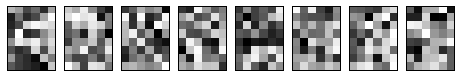

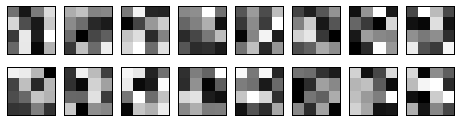

(5320, 223.0, 1.0, 0.9997120000000095)


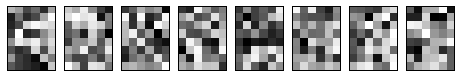

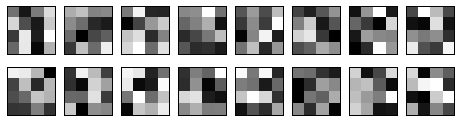

(5520, 200.0, 1.0, 0.9995320000000154)


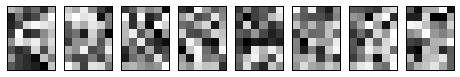

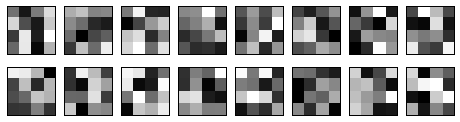

(5783, 263.0, 2.0, 0.9992953000000232)


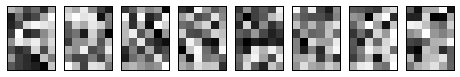

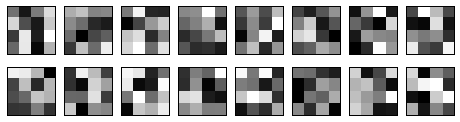

Evaluated model
(163, 0.0)
(5946, 263.0, 2.0, 0.9992953000000232)


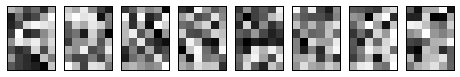

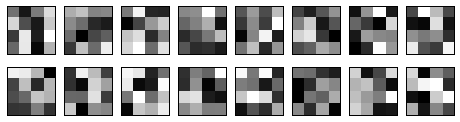

(6107, 161.0, 0.0, 0.999150400000028)


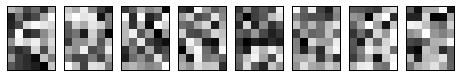

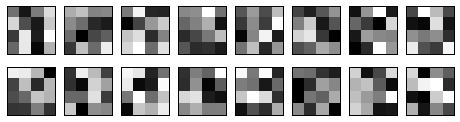

(6329, 222.0, 1.0, 0.9989506000000345)


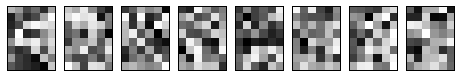

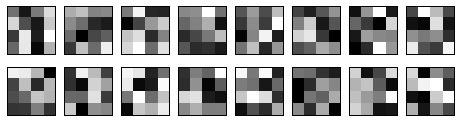

(6530, 201.0, 1.0, 0.9987697000000405)


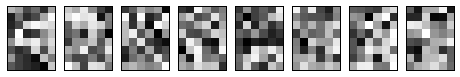

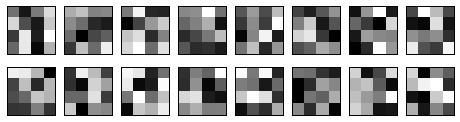

(6832, 302.0, 3.0, 0.9984979000000495)


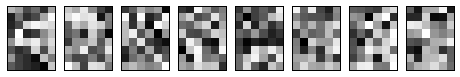

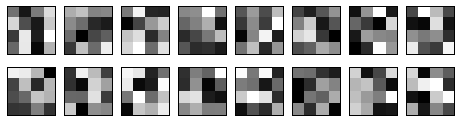

Evaluated model
(491, 6.0)
(7323, 302.0, 3.0, 0.9984979000000495)


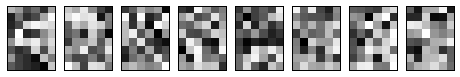

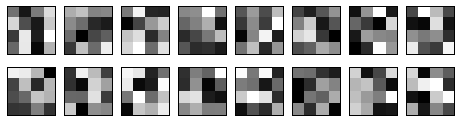

(7585, 262.0, 2.0, 0.9982621000000572)


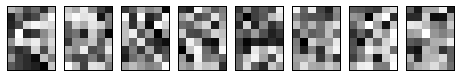

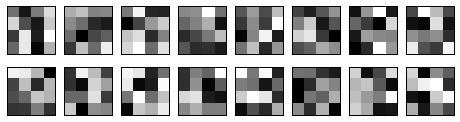

(7833, 248.0, 2.0, 0.9980389000000646)


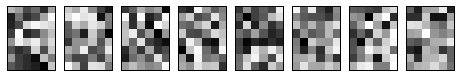

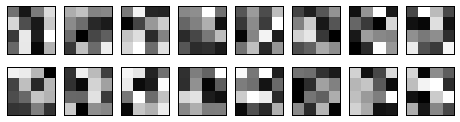

(8234, 401.0, 4.0, 0.9976780000000764)


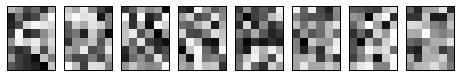

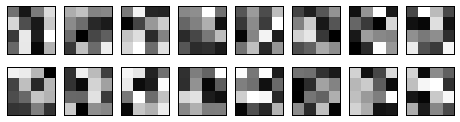

(8521, 287.0, 2.0, 0.997419700000085)


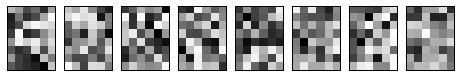

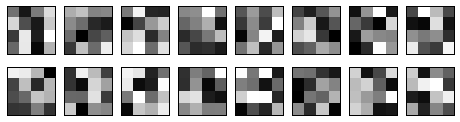

Evaluated model
(230, 1.0)
(8751, 287.0, 2.0, 0.997419700000085)


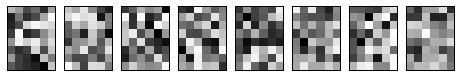

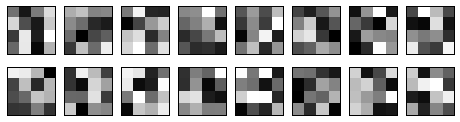

(9078, 327.0, 3.0, 0.9971254000000946)


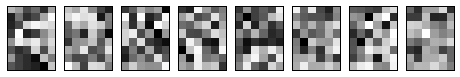

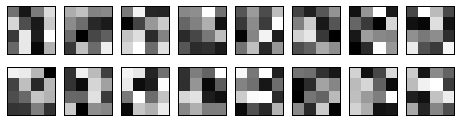

(9350, 272.0, 3.0, 0.9968806000001027)


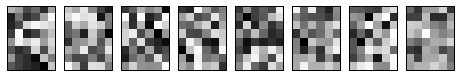

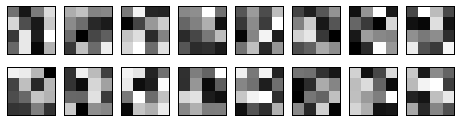

In [ ]:
tf.reset_default_graph()

mainQN = protoQnetwork(h_size, mover_prototypes, \
                       mover_disps, 3, 'mainQN', True)
targetQN = protoQnetwork(h_size, mover_prototypes, \
                       mover_disps, 3, 'targetQN', True)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

trainables = tf.trainable_variables()

targetOps = updateTargetGraph(trainables,tau)

myBuffer = experience_buffer()

#Set the rate of random action decrease. 
e = startE
stepDrop = (startE - endE)/anneling_steps

#create lists to contain total rewards and steps per episode
jList = []
rList = []
total_steps = 0

#statistics on Q
Qpred_list = []
Qtarget_list = []
QrList = []

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path)

sess = tf.Session()
#with tf.Session() as sess:
sess.run(init)
if load_model == True:
    print('Loading Model...')
    ckpt = tf.train.get_checkpoint_state(path)
    saver.restore(sess,ckpt.model_checkpoint_path)

updateTarget(targetOps,sess) #Set the target network to be equal to the primary network.
for i in range(num_episodes):
    episodeBuffer = experience_buffer()
    #Reset environment and get first new observation(s)
    s_list, r, d, info = initial_obs(env, breakout)
    s_stack = np.dstack(s_list)
    s = processState(s_stack)

    d = False
    rAll = 0
    j = 0

    # periodically evaluate
    if i % 5 == 0 and total_steps  > pre_train_steps:
        eval_episode = True
        saved_e = e
        e = 0.1
    else:
        eval_episode = False
    #The Q-Network
    while j < max_epLength: #If the agent takes longer than 200 moves to reach either of the blocks, end the trial.
        j+=1
        
        #plt.imshow(env.render('rgb_array'))
        #plt.show()
        
        #Choose an action by greedily (with e chance of random action) from the Q-network
        if np.random.rand(1) < e or total_steps < pre_train_steps:
            a = np.random.randint(0,env.action_space.n)
        else:
            a = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:[s]})[0]
        
        if breakout and np.array_equal(s_list[0],s_list[1]):
            # breakout: requesting next ball
            a = 1
        
        s_next,r,d,info = env.step(a)
        #s_next = cv2.cvtColor(s_next, cv2.COLOR_BGR2GRAY)

        s_list.pop(0)
        s_list.append(s_next)

        s_stack = np.dstack(s_list)
        s1 = processState(s_stack)

        total_steps += 1
        if (r > 0) or d:
            buffer_repeat = 1
        else:
            buffer_repeat = 1
        for dummy in range(buffer_repeat):
            episodeBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5]),reward_prop) #Save the experience to our episode buffer.

        if total_steps > pre_train_steps and not eval_episode:
            if e > endE:
                e -= stepDrop

            if total_steps % (update_freq) == 0:
                trainBatch = myBuffer.sample(batch_size) #Get a random batch of experiences.
                #Below we perform the Double-DQN update to the target Q-values
                Q1 = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,3])})
                Q2 = sess.run(targetQN.Qout,feed_dict={targetQN.scalarInput:np.vstack(trainBatch[:,3])})
                end_multiplier = -(trainBatch[:,4] - 1)
                doubleQ = Q2[range(batch_size),Q1]
                targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                Qtarget_list.extend(targetQ)
                predQ = sess.run(mainQN.Q, \
                    feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]), mainQN.actions:trainBatch[:,1]})
                Qpred_list.extend(predQ)
                QrList.extend(trainBatch[:,2])
                #Update the network with our target values.
                _ = sess.run(mainQN.updateModel, \
                    feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]),mainQN.targetQ:targetQ, mainQN.actions:trainBatch[:,1]})
                updateTarget(targetOps,sess) #Set the target network to be equal to the primary network.
        rAll += r
        s = s1

        if d == True:
            break
    #print(j)
    if not eval_episode:
        myBuffer.add(episodeBuffer.buffer,False)
        jList.append(j)
        rList.append(rAll)
    else:
        print("Evaluated model")
        print(j, rAll)
        e = saved_e
    #Periodically save the model. 
    if i % 100 == 0:
        saver.save(sess,path+'/model-'+str(i)+'.cptk')
        print("Saved Model")
    print_rate = 1
    if len(rList) % print_rate == 0 and total_steps > pre_train_steps:
        print(total_steps,
              np.mean(jList[-print_rate:]),
              np.mean(rList[-print_rate:]), 
              e)
        all_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
        
        test_weights=[v for v in all_vars \
         if v.name == 'Conv/weights:0'][0]\
        .eval(session=sess)
        
        q_weights=[v for v in all_vars \
         if v.name == 'Conv_1/weights:0'][0]\
        .eval(session=sess)
        
        i_max=1
        j_max=8
        plt.figure(figsize=(8,4))
        for i in range(i_max):
            for j in range(j_max):
                cmap_max = max(np.max(q_weights[:,:,i,j]),
                              -np.min(q_weights[:,:,i,j]))
                plt.subplot(i_max,j_max,j+(i*j_max)+1)
                plt.xticks([])
                plt.yticks([])
                plt.imshow(q_weights[:,:,i,j],cmap='gray',
                interpolation='nearest',
                vmin=-cmap_max,vmax=cmap_max)
        plt.show()
        
        i_max=2
        j_max=8
        plt.figure(figsize=(8,2))
        for i in range(i_max):
            for j in range(j_max):
                cmap_max = max(np.max(test_weights[:,:,j+(i*j_max),0]),
                              -np.min(test_weights[:,:,j+(i*j_max),0]))
                plt.subplot(i_max,j_max,j+(i*j_max)+1)
                plt.xticks([])
                plt.yticks([])
                plt.imshow(test_weights[:,:,j+(i*j_max),0],cmap='gray',
                interpolation='nearest',
                          vmin=-cmap_max,vmax=cmap_max)
        plt.show()
        
saver.save(sess,path+'/model-'+str(i)+'.cptk')
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

In [135]:
q_weights.shape

(8, 6, 16, 8)

In [73]:
avg_reward = np.mean([e[2] for e in myBuffer.buffer])
avg_stable_q = avg_reward / (1-y)
print avg_stable_q

0.124392228562


In [78]:
Qtarget_list = Qtarget_list[:160416]

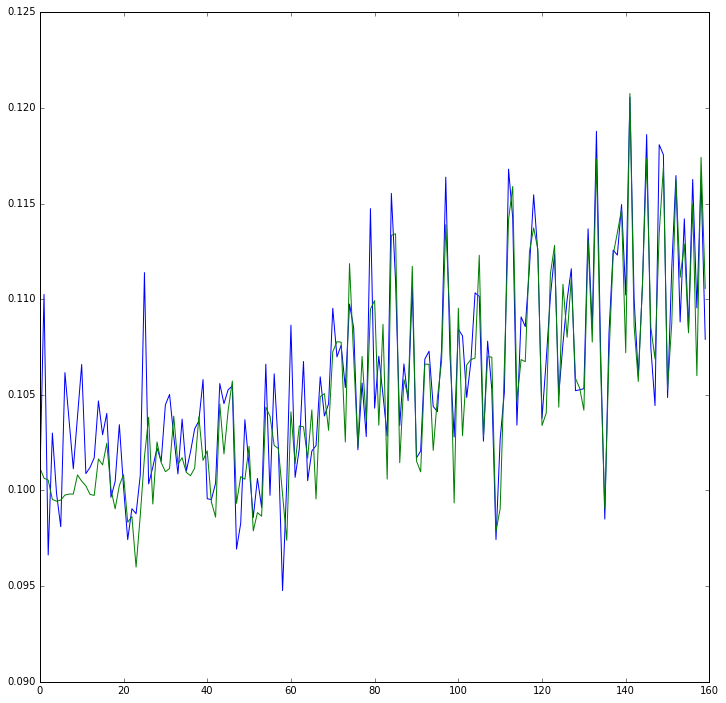

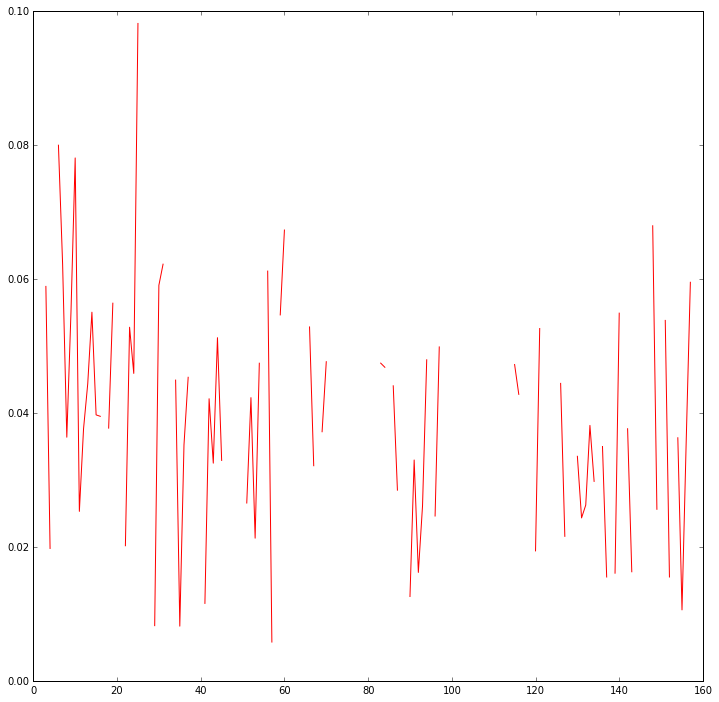

In [81]:
avg_window = 1000

plt.figure(figsize=(12,12))
QtMat = np.resize(np.array(Qtarget_list),[len(Qtarget_list)//avg_window,avg_window])
QtAvgs = np.average(QtMat,1)
plt.plot(QtAvgs)

QpMat = np.resize(np.array(Qpred_list),[len(Qpred_list)//avg_window,avg_window])
QpAvgs = np.average(QpMat,1)
plt.plot(QpAvgs)

plt.figure(figsize=(12,12))
losses = np.array(Qtarget_list)-np.array(Qpred_list)
lossMat = np.resize(losses,[len(losses)//avg_window,avg_window])
lossAvgs = np.sqrt(np.average(lossMat,1))
plt.plot(lossAvgs,'r')

In [82]:
len(Qtarget_list)

160416

[[ 1.        0.841028]
 [ 0.841028  1.      ]]


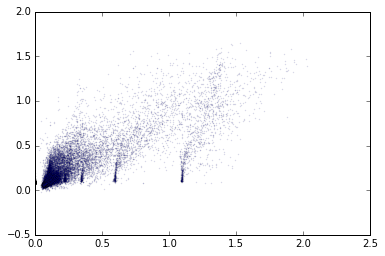

In [87]:
plt.plot(Qtarget_list,Qpred_list,'o',markersize=1,alpha=0.1)
print np.corrcoef(Qtarget_list,Qpred_list)

In [88]:
cols = []
Qpred_list = np.array(Qpred_list)
rOptions = np.unique(QrList)
for r in rOptions:
    cols.append(Qpred_list[QrList==r])

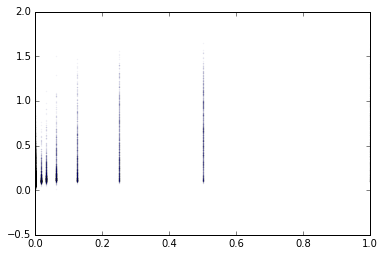

In [89]:
plt.plot(QrList,Qpred_list,'o',markersize=1,alpha=0.035)

In [90]:
buffer_all = np.array(myBuffer.buffer)
(buffer_all[:,2]>0).mean()

0.043880093225106484

### Some tests and visualizations

[2017-05-27 20:49:22,031] Making new env: Breakout-v0


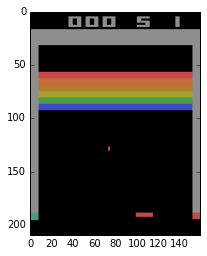

action: 0


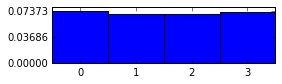

q


In [116]:
env = gym.make(env_title)
s_list, r, d, info = initial_obs(env, breakout)
s_stack = np.dstack(s_list)
s = processState(s_stack)

d = False
rAll = 0
j = 0

e = 0

while j < max_epLength:
    j+=1

    plt.figure()
    plt.imshow(s_stack[:,:,3:])
    plt.show()

    #Choose an action by greedily (with e chance of random action) from the Q-network
    if np.random.rand(1) < e or total_steps < pre_train_steps:
        a = np.random.randint(0,env.action_space.n)
        print 'random action: ' + str(a)
    else:
        a = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:[s]})[0]
        print 'action: ' + str(a)
    if np.array_equal(s_list[0],s_list[1]):
        a = 1
    
    Qout = sess.run(mainQN.Qout,feed_dict={mainQN.scalarInput:[s]})[0]
    Qout_target = sess.run(targetQN.Qout,feed_dict={targetQN.scalarInput:[s]})[0]
    if True:#np.var(Qout) > 0:
        plt.figure(figsize=(4,1))
        plt.bar(np.arange(4)-0.5,Qout,width=1)
        plt.xticks(range(4));
        plt.yticks(np.linspace(0,max(Qout),3));
        plt.show()
        if j%1 == 0:
            if raw_input() == 'q':
                break

    
    s_next,r,d,info = env.step(a)
    
    
    s_list.pop(0)
    s_list.append(s_next)

    s_stack = np.dstack(s_list)
    s1 = processState(s_stack)

    rAll += r
    s = s1

    if d == True:
        break

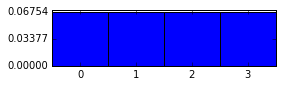

In [112]:
plt.figure(figsize=(4,1))
plt.bar(np.arange(4)-0.5,Qout,width=1)
plt.xticks(range(4));
plt.yticks(np.linspace(0,max(Qout),3));

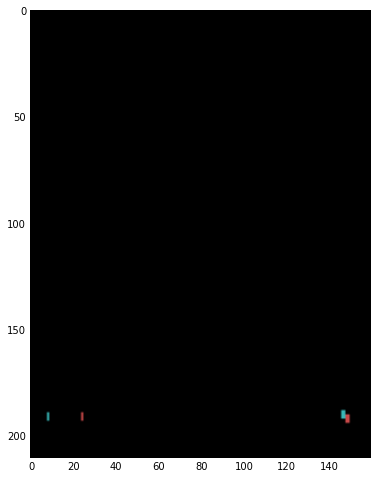

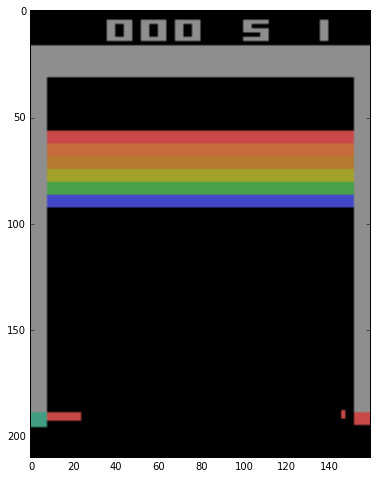

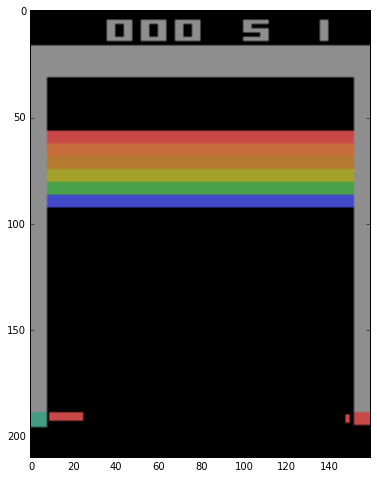

In [901]:
plt.figure(figsize=(12,8))
plt.imshow(s_stack[:,:,3:]-s_stack[:,:,:3])
plt.figure(figsize=(12,8))
plt.imshow(s_stack[:,:,:3])
plt.figure(figsize=(12,8))

plt.imshow(s_stack[:,:,3:])

In [902]:
sess.run(mainQN.conv2,feed_dict={mainQN.scalarInput:[s]})

array([[[[-0.00875617, -0.01546426, -0.00618444, -0.00656676, -0.00902274,
          -0.02128692, -0.01523175,  0.11306629]]]], dtype=float32)

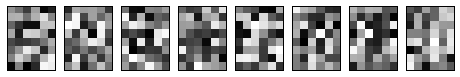

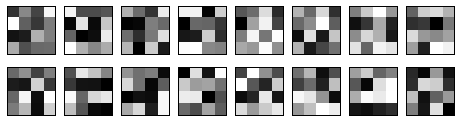

In [147]:
all_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)

#test_kernel=[v for v in all_vars \
# if v.name == 'mainQN/piaget/mover_disps/mover0/disp2/kernel:0'][0]\
#.eval(session=sess)

test_weights=[v for v in all_vars \
 if v.name == 'Conv/weights:0'][0]\
.eval(session=sess)

q_weights=[v for v in all_vars \
 if v.name == 'Conv_1/weights:0'][0]\
.eval(session=sess)

i_max=1
j_max=8
plt.figure(figsize=(8,2))
for i in range(i_max):
    for j in range(j_max):
        cmap_max = max(np.max(q_weights[:,:,i,j]),
                      -np.min(q_weights[:,:,i,j]))
        plt.subplot(i_max,j_max,j+(i*j_max)+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(q_weights[:,:,i,j],cmap='gray',
        interpolation='nearest',
        vmin=-cmap_max,vmax=cmap_max)
plt.show()

i_max=2
j_max=8
plt.figure(figsize=(8,2))
for i in range(i_max):
    for j in range(j_max):
        cmap_max = max(np.max(test_weights[:,:,j+(i*j_max),0]),
                      -np.min(test_weights[:,:,j+(i*j_max),0]))
        plt.subplot(i_max,j_max,j+(i*j_max)+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(test_weights[:,:,j+(i*j_max),0],cmap='gray',
        interpolation='nearest',
                  vmin=-cmap_max,vmax=cmap_max)
plt.show()

In [144]:
plt.axis?

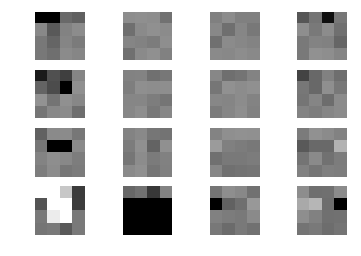

In [904]:
test_weights.shape
i_max=4
j_max=4
for i in range(i_max):
    for j in range(j_max):
        plt.subplot(i_max,j_max,j+(i*j_max)+1)
        plt.axis('off')
        plt.imshow(test_weights[:,:,j+(i*j_max),0],cmap='gray',
        interpolation='nearest',
                  vmin=-1,vmax=1)

In [905]:
#c0=sess.run(mainQN.conv_movers,feed_dict={mainQN.scalarInput:[s]})
c1=sess.run(mainQN.conv_dm_pool,feed_dict={mainQN.scalarInput:[s]})
c2=sess.run(mainQN.conv1_pool,feed_dict={mainQN.scalarInput:[s]})
c3=sess.run(mainQN.conv2,feed_dict={mainQN.scalarInput:[s]})

In [906]:
print c1.shape
print c2.shape
print c3.shape

(1, 52, 40, 16)
(1, 8, 6, 4)
(1, 1, 1, 8)


In [907]:
[[mover_disps[0][j],np.max(c1[0,:,:,j])] for j in range(10)]

IndexError: list index out of range

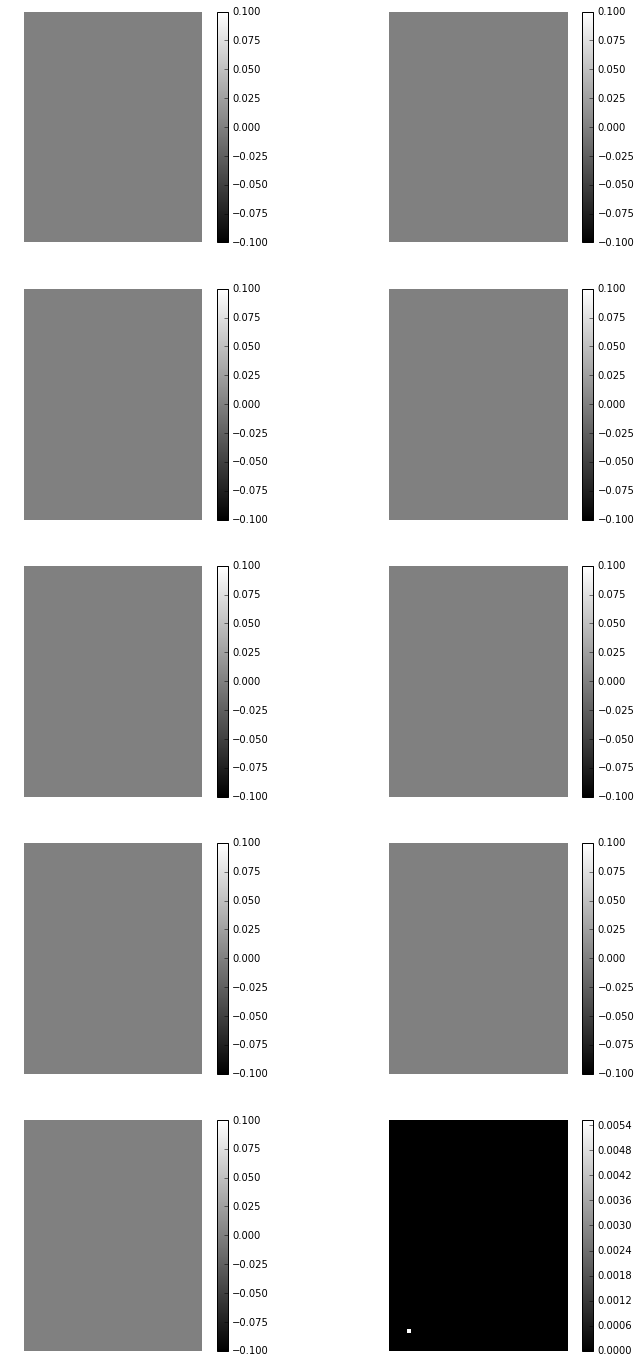

In [908]:
plt.figure(figsize=(12,24))
i_max=5
j_max=2
for i in range(i_max):
    for j in range(j_max):
        plt.subplot(i_max,j_max,j+(i*j_max)+1)
        plt.axis('off')
        im = c1[0,:,:,j+(i*j_max)]
        plt.imshow(im,cmap='gray',
        interpolation='nearest')
        plt.colorbar()

In [ ]:
[(i, np.max(c3[0,:,:,i])) for i in range(16)]

In [602]:
test = reduce(lambda a,b: a+b, mover_disps)
test[8]

(-2, 2)

In [603]:
for index in range(16):
    #print(test[index])
    plt.figure(figsize=(12,8))
    plt.imshow(c1[0,:,:,3]-c0[0,:,:,2],interpolation='nearest')
    plt.colorbar()
    plt.figure(figsize=(6,4))
    plt.imshow(c3[0,:,:,index],interpolation='nearest')
    plt.colorbar()

NameError: name 'c0' is not defined

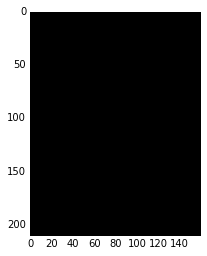

In [971]:
plt.imshow(s_stack[:,:,3:]-s_stack[:,:,:3])

### Checking network learning

Mean reward over time

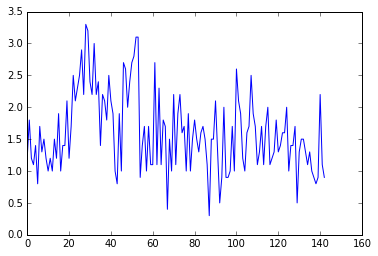

In [897]:
rMat = np.resize(np.array(rList),[len(rList)//10,10])
rMean = np.average(rMat,1)
plt.plot(rMean)